In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression as MIR
import tensorflow as tf
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.utils import plot_model, to_categorical   
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# # days start interval
# SURVIVAL_CATEGORIES= {
#     'SHORT' : 0 , # 0-300
#     'MEDIUM' : 250,  # 300-450
#     'LONG' : 450, # 450 and more
# }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='./MICCAI_BraTS2020_TrainingData/'
VAL_DATASET_PATH='./MICCAI_BraTS2020_ValidationData/'

In [3]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories+= [f.path for f in os.scandir(VAL_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

In [4]:
print(train_and_val_directories)

['./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_002', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_003', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_004', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_005', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_006', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_007', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_008', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_009', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_010', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_011', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_012', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_013', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_014', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_015', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_016', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_017', './MICCAI_BraTS2020_TrainingData/BraTS20_Traini

In [5]:
import csv

csvs = [r'MICCAI_BraTS2020_TrainingData\survival_info.csv', r'MICCAI_BraTS2020_ValidationData\survival_evaluation.csv']

age_dict = {}
days_dict = {}
at_line = 0
category_short = 0
category_medium = 0
category_long = 0
max_days = 0
for csv_path in csvs:
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file,delimiter = ',')
    #  row_count = sum(1 for row in csv_reader)
    #   print(f'total rows: {row_count} .')
        for row in csv_reader:
            if at_line == 0:
                # print(f'Column names are {", ".join(row)}')
                at_line += 1
            else:
                if (row[-1] != "GTR"):
                    continue
                # print(row)
                key = row[0]
                age = row[1]
                days = row[2]
                age_dict[key] = float(age)
                if (not days.isnumeric()):
                    continue
                days_dict[key] = int(days)
                max_days = max(max_days,int(days))
                if int(days) < 250:
                    category_short += 1
                elif (int(days) >= 250 and int(days) <= 450):
                    category_medium += 1
                else:
                    category_long += 1
                at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Processed 119 lines.
34 38 46
1767
Processed 119 lines.
34 38 46
1767


In [6]:
import csv

def col_and_eval(ch_ft = []):
    id_list2 = []
    csv_filenames = [r'.\results.csv',r'.\results_val.csv']
    dt =[]
    jj = [] #key_list
    id_tp = 0
    row_cc = 0
    row2 = {}
    id_check = {}
    for csv_filename in csv_filenames:
        with open(csv_filename) as f:
            reader = csv.DictReader(f)
            for row in reader:
                # if row_cc > 20:
                #     break
                # row_cc += 1
                dt_tp = row
                if row['Patient_ID'] not in id_check:
                    id_check[row['Patient_ID']] = 0
                id_check[row['Patient_ID']] += 1
                if len(id_list2) != 0:
                    if id_list2[-1] == row["Patient_ID"]:
                        id_tp += 1
                    else:
                        dt.append(row2)
                        row2 = {}
                        id_tp = 0
                if id_tp == 0:
                    id_list2.append(row["Patient_ID"])
                if len(id_list2) == 1:
                    for keysj in row:
                        if keysj != None:
                            if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                                continue
                            # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                            row[keysj] = eval(row[keysj])
                            if isinstance(row[keysj],tuple):
                                ct = 0
                                for it in row[keysj]:
                                    keysjn = keysj + str(ct)
                                    keysjn += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                    if (keysjn in ch_ft) or (len(ch_ft) == 0):
                                        jj.append(keysjn)
                                    ct += 1
                                continue
                            keysj += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                            if (keysj in ch_ft) or (len(ch_ft) == 0):
                                jj.append(keysj)
                for keysj in row:
                    if keysj != None:
                        if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                            continue
                        # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                        row[keysj] = eval(str(row[keysj]))
                        keys2j = keysj + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                        if isinstance(row[keysj],tuple):
                            ct = 0
                            for it in row[keysj]:
                                keys2j =  keysj + str(ct) + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                row2[keys2j] = it
                                ct += 1
                            continue
                        row2[keys2j] = row[keysj]
                row2['Patient_ID'] = row['Patient_ID']
    dt.append(row2)    
    return dt, jj

# print(jj)
# print(dt)
# create only age: category data


In [7]:
# id: age, categories
def getListAgeDays(id_list, dt, jj, ch_ft = []):
    x_val = []
    y_val = []
    x_test = []
    for i in dt:
        if ((i["Patient_ID"] not in days_dict) and ("Validation" not in i["Patient_ID"])):
            # print(i["Patient_ID"])
            continue
        # if (i not in id_list2):
        #     continue
        # masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii.gz').get_fdata())
        # brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii.gz').get_fdata())
        # masks[1] = masks[1]/brain_vol
        # masks[2] = masks[2]/brain_vol
        # masks[3] = masks[3]/brain_vol
        # merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        # ft = dt[]
        if (i["Patient_ID"] not in age_dict):
            continue
        j = [age_dict[i["Patient_ID"]]]
        for keysj in i:
            if keysj != None:
                if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                    continue
                if (keysj not in ch_ft) and (len(ch_ft) != 0):
                    continue
                # if(i[keysj][0]=='('):
                #     i[keysj] = tuple(i[keysj])
                # else:
                # print(i[keysj])
                # i[keysj] = eval(i[keysj])
                # if isinstance(i[keysj],tuple):
                #     ct = 0
                #     for it in i[keysj]:
                #         keysjn = keysj + str(ct)
                #         j.append(it)
                #         ct += 1
                #     continue
                j.append(i[keysj])
        # print(j)
        if "Validation" in i["Patient_ID"]:
            # print("vvv"+i["Patient_ID"])
            x_test.append(j)
        else:
            x_val.append(j) 
            y_val.append(days_dict[i["Patient_ID"]])
        # if (days_dict[i["Patient_ID"]] < 250):
        #     y_val.append(0)
        # elif (days_dict[i["Patient_ID"]] >= 250 and days_dict[i["Patient_ID"]] < 450):
        #     y_val.append(1)
        # else:
        #     y_val.append(2)
            
    return np.array(x_val), np.array(y_val), np.array(x_test)

dt, jj = col_and_eval()
X_all, y_all, x_val = getListAgeDays(train_and_test_ids,dt,jj)
print(len(train_and_test_ids))
print(X_all.shape)
print(y_all.shape)
print(x_val.shape)
print(f'X_all: {X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
dfn = np.concatenate((X_all, y_all[:,None]), axis=1)
print(dfn.shape,len(columns))
df = pd.DataFrame(dfn, columns = columns)
df2 = pd.DataFrame(x_val,columns = ["age"]+jj)
df2.head()

493
(117, 10701)
(117,)
(28, 10701)
X_all: (117, 10701)
['age', 'original_shape_Elongation_flair', 'original_shape_Flatness_flair', 'original_shape_LeastAxisLength_flair', 'original_shape_MajorAxisLength_flair', 'original_shape_Maximum2DDiameterColumn_flair', 'original_shape_Maximum2DDiameterRow_flair', 'original_shape_Maximum2DDiameterSlice_flair', 'original_shape_Maximum3DDiameter_flair', 'original_shape_MeshVolume_flair', 'original_shape_MinorAxisLength_flair', 'original_shape_Sphericity_flair', 'original_shape_SurfaceArea_flair', 'original_shape_SurfaceVolumeRatio_flair', 'original_shape_VoxelVolume_flair', 'original_firstorder_10Percentile_flair', 'original_firstorder_90Percentile_flair', 'original_firstorder_Energy_flair', 'original_firstorder_Entropy_flair', 'original_firstorder_InterquartileRange_flair', 'original_firstorder_Kurtosis_flair', 'original_firstorder_Maximum_flair', 'original_firstorder_MeanAbsoluteDeviation_flair', 'original_firstorder_Mean_flair', 'original_firsto

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,68.170,0.708109,0.549494,44.532841,81.043346,77.491935,89.944427,82.540899,91.181138,90802.87500,...,1.388889e-02,1.388889e-02,1.000000e+00,0.000022,2.063521e+09,0.0,1000000.0,0.0,0.0,0.0
1,50.153,0.713522,0.581695,28.423128,48.862599,48.662100,50.606324,42.011903,51.662365,19210.95833,...,2.700000e-09,2.700000e-09,-3.200000e-16,0.000052,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0
2,21.726,0.572874,0.488275,47.082522,96.426173,70.830784,110.367568,99.609237,110.742946,59501.04167,...,2.812822e-02,2.812822e-02,2.000000e+00,0.000067,6.654277e+08,0.0,1000000.0,0.0,0.0,0.0
3,55.482,0.647488,0.498546,45.320963,90.906282,70.576200,94.339811,94.085068,94.620294,99705.66667,...,1.676474e-01,1.676474e-01,2.584963e+00,0.000060,1.381898e+09,0.0,1000000.0,0.0,0.0,0.0
4,64.753,0.729476,0.516040,43.413481,84.128141,80.000000,84.403791,80.056230,87.464278,57203.79167,...,1.718748e-01,1.718748e-01,2.405639e+00,0.000140,3.572158e+08,0.0,1000000.0,0.0,0.0,0.0


In [8]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled
X_val = scaler.fit_transform(x_val)

df = pd.DataFrame(X_all, columns = ["age"]+jj)
# display(df)
df2 = pd.DataFrame(X_val,columns = ["age"]+jj)
df2.head()

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.726244,0.414664,0.554768,0.618613,0.703363,0.864464,0.717478,0.746378,0.730597,0.678942,...,2.777778e-02,2.777778e-02,0.356207,0.007783,0.804518,0.0,0.0,0.0,0.0,0.0
1,0.444512,0.427461,0.639311,0.213227,0.207936,0.257954,0.173298,0.144148,0.186348,0.103571,...,5.283200e-09,5.283200e-09,0.000000,0.024042,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.094908,0.394040,0.682773,0.940184,0.724329,1.000000,1.000000,1.000000,0.427375,...,5.625643e-02,5.625643e-02,0.712414,0.032172,0.259434,0.0,0.0,0.0,0.0,0.0
3,0.527842,0.271328,0.421005,0.638445,0.855204,0.718974,0.778281,0.917915,0.777960,0.750492,...,3.352948e-01,3.352948e-01,0.920782,0.028378,0.538769,0.0,0.0,0.0,0.0,0.0
4,0.672812,0.465184,0.466935,0.590445,0.750854,0.917228,0.640832,0.709457,0.679408,0.408912,...,3.437496e-01,3.437496e-01,0.856906,0.071481,0.139270,0.0,0.0,0.0,0.0,0.0


In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
X_train = X_all
y_train = y_all
print("x_train shape:",X_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 10701)
y_train shape: (117,)


In [10]:
from skfeature.function.similarity_based import fisher_score

print(X_train.shape,y_train.shape)
_ranks = fisher_score.fisher_score(X_train,y_train)

(117, 10701) (117,)


c:\Python310\lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


In [11]:
# ft_sc = {}
# ii = 0
# columns = ["age"]+jj
# for it in columns[:-1]:
#     ft_sc[it] = _ranks[ii]
#     ii += 1

# sorted_ft_sc = sorted(ft_sc.items(), key=lambda x:x[1], reverse=True)
# sorted_ft_sc = dict(sorted_ft_sc)
# print(sorted_ft_sc)
# print(_ranks)
# print(columns[_ranks[0]])

In [12]:
# ij = 0
# chosen_ft = {}
# for it in sorted_ft_sc:
#     chosen_ft[it] = sorted_ft_sc[it]
#     ij += 1
#     if ij>=400:
#         break

# print(chosen_ft)

In [13]:
columns = ["age"]+jj
colnew = []
def prune2(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if _ranks[iter]<400:
                xxtp.append(col)
                if columns[iter] not in colnew:
                    colnew.append(columns[iter])
            iter += 1
        xx.append(xxtp)
    return xx

x_train = np.array(prune2(X_train))
x_test = np.array(prune2(X_val))

print(x_train.shape)
print(x_test.shape)
df = pd.DataFrame(x_train, columns = colnew)
df2 = pd.DataFrame(x_test,columns = colnew)
# df2.head()
df.head()

(117, 400)
(28, 400)


,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.0,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.0,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.0,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.0,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.0,0.068392,0.0,0.116146


In [14]:
# dt, jj = col_and_eval(chosen_ft)

In [15]:
# ch_X_all, ch_y_all, ch_x_test = getListAgeDays(train_and_test_ids,dt,jj,ch_ft=chosen_ft)
# print(len(train_and_test_ids))
# print(ch_X_all.shape)
# print(ch_x_test.shape)
# print(ch_y_all.shape)
# columns = ["age"]+jj+["prediction"]
# print(columns)
# ch_dfn = np.concatenate((ch_X_all, ch_y_all[:,None]), axis=1)
# print(ch_dfn.shape,len(columns))
# df = pd.DataFrame(ch_dfn, columns = columns)
# df2 = pd.DataFrame(ch_x_test,columns = ["age"]+jj)
# df2.head()
# df.head()

In [16]:
scaler = MinMaxScaler()
v = x_train
v_scaled = scaler.fit_transform(v)
x_train = v_scaled
v = x_test
v_scaled = scaler.fit_transform(v)
x_test = v_scaled

df = pd.DataFrame(x_train, columns = colnew)
display(df)

,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.00,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.00,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.00,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.00,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.00,0.068392,0.0,0.116146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.522913,0.281444,0.814210,0.005661,0.241904,0.000000,0.344601,0.140379,0.042005,0.000000,...,0.488836,0.476993,0.257988,0.072479,0.231555,0.5,1.00,0.268073,0.0,0.110025
113,0.492875,0.392684,0.802848,0.020952,0.318705,0.141052,0.277558,0.093331,0.062563,0.174523,...,0.599050,0.500579,0.383955,0.045440,0.434880,0.5,0.75,0.436602,0.0,0.296937
114,0.430218,0.330815,0.815283,0.009775,0.323282,0.057158,0.067648,0.204677,0.016764,0.200776,...,0.254618,0.707799,0.084903,0.091646,0.069980,0.5,0.50,0.061314,0.0,0.422460
115,0.380998,0.252184,0.860577,0.446064,0.467367,1.000000,0.004014,0.002010,0.586474,0.868604,...,0.306783,0.301750,0.064500,0.301888,0.022748,0.5,0.75,0.022454,0.0,0.322749


In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
# x_train = ch_X_all
# y_train = ch_y_all
# x_test = ch_x_test
print("x_train shape:",x_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 400)
y_train shape: (117,)


**# mrmr implementation**

In [18]:
def rank(X,y,nbSolutions,I_xy):
    f_mir = []
    for i in range(int(X.shape[1])):
        f_mir.append([I_xy[i],i])
    f_mir.sort(reverse=True)
    S=[]
    si = []
    for i in range(nbSolutions):
        si.append(f_mir[i][1])
        S.append(si)
        si = []
    return S

In [49]:
def score(f,Si,I_xy,I_xx):
    if f == -1:
        return float("-INF")
    mi_temp = 0
    qj = I_xy[f]
    if len(Si):
        for xi in Si:
            mi_temp += I_xx[xi][f]
        mi_temp/=len(Si)
    qj += mi_temp
    return qj

In [45]:
def btstrap(X,y,m):
    x_new = np.concatenate((X,y[:,None]),axis = 1)
    df = pd.DataFrame(x_new)
    df_new = df.sample(n=m, replace=True)
    z = df_new.to_numpy()
    _X = z[:,:-1]
    _y = z[:,-1]
    print(_X,_y)
    return _X, _y

In [48]:
#Mutual Implementation
def MIR_train(x_train,y_train):
    I_xx = np.zeros((x_train.shape[1],x_train.shape[1]))
    I_xy = np.zeros(x_train.shape[1])
    print(I_xx.shape,I_xy.shape)

    i1=0
    for f1 in x_train.T:
        # print(res)
        # I_xx[i1][i2] = (-0.5)*math.log(1-(res*res))
        I_xx[i1] = MIR(x_train,list(f1))
        i1 += 1
        print(f"Processed MI with {i1} features so far...")
    I_xy = MIR(x_train,list(y_train))
    return I_xx,I_xy
#each iteration taking ~30s and 10702 such iterations. thus, IMPOSSIBLE

In [21]:
# I_xy = MIR(x_train,list(y_train))

In [50]:
# S= rank(x_train,y_train,10,I_xy)

lenSol = 25
nbSol = 10
m = 20
i = 0
S=[]

while i < nbSol:
    X_n, y_n = btstrap(x_train,y_train,m)
    print(X_n.shape,y_n.shape)
    I_xx,I_xy = MIR_train(X_n,y_n)
    Si = []
    l = 1
    while l <= lenSol:
        c = -1
        for f in range(int(x_train.shape[1])):
            if f in Si:
                continue
            if score(f,Si,I_xy,I_xx)>=score(c,Si,I_xy,I_xx):
                c = f
        Si.append(c)
        l += 1
    print(Si)
    S.append(Si)
    i += 1

print(len(S),len(S[0]))
print(S)


[[0.722 0.345 0.859 ... 0.068 0.    0.297]
 [0.404 0.387 0.812 ... 0.14  0.    0.193]
 [0.145 0.266 0.775 ... 0.018 0.    0.484]
 ...
 [0.85  0.34  0.8   ... 0.495 0.    0.351]
 [0.662 0.161 0.82  ... 0.072 0.    0.107]
 [0.578 0.202 0.8   ... 0.06  0.    0.282]] [ 688.  439.  692.  540.   84.  376.  169. 1767.   62.  146.   62.  146.
  439.   58.  277.  331.  208.  613.  191. 1410.]
(20, 400) (20,)
(400, 400) (400,)
Processed MI with 1 features so far...
Processed MI with 2 features so far...
Processed MI with 3 features so far...
Processed MI with 4 features so far...
Processed MI with 5 features so far...
Processed MI with 6 features so far...
Processed MI with 7 features so far...
Processed MI with 8 features so far...
Processed MI with 9 features so far...
Processed MI with 10 features so far...
Processed MI with 11 features so far...
Processed MI with 12 features so far...
Processed MI with 13 features so far...
Processed MI with 14 features so far...
Processed MI with 15 feature

In [51]:
def prune(X,Si):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if iter in Si:
                xxtp.append(col)
            iter += 1
        xx.append(xxtp)
    return xx

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [53]:
from sklearn.metrics import mean_squared_error
import statistics
from scipy import stats

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions)
    med_arr = [(yt-yp)*(yt-yp) for yt,yp in zip(predictions,test_labels)]
    return mean_squared_error(test_labels,predictions),statistics.median(med_arr),statistics.stdev(med_arr),stats.spearmanr(test_labels,predictions),predictions


In [54]:
def classif(y_train,y_pred):  
    y_train_v = []
    y_pred_v = []
    for yi in y_train:
        if (yi < 300):
            y_train_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_train_v.append(1)
        else:
            y_train_v.append(2)

    for yi in y_pred:
        if (yi < 300):
            y_pred_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_pred_v.append(1)
        else:
            y_pred_v.append(2)
    return y_train_v,y_pred_v

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[274.27  453.951 421.841 634.008 539.313 425.46  551.199 658.34  557.992
 476.269 607.707 375.269 347.026 515.56  481.547 539.095 337.729 523.794
 446.958 524.051 399.953 370.706 463.022 720.071 329.04  322.335 313.462
 638.006 602.438 460.582 526.321 307.011 268.793 396.891 363.904 437.121
 500.533 841.515 354.627 332.074 508.05  477.946 475.55  333.39  271.829
 327.691 747.469 311.778 357.213 374.304 271.314 304.159 397.304 302.706
 489.419 373.689 467.275 471.259 375.054 242.997 752.186 349.818 254.501
 235.573 676.532 323.164 334.673 707.819 274.517 539.002 238.187 466.994
 569.384 505.973 419.915 203.422 574.705 487.543 291.958 418.164 429.94
 341.774 435.432 393.027 464.108 373.667 440.548 416.755 598.707 739.836
 534.404 406.674 613.516 339.877 328.515 441.338 535.362 353.805 701.841
 552.147 654.311 388.181 562.592 449.35  730.353 326.166 743.88  488.507
 545.015 423.282 458.164 465.378 

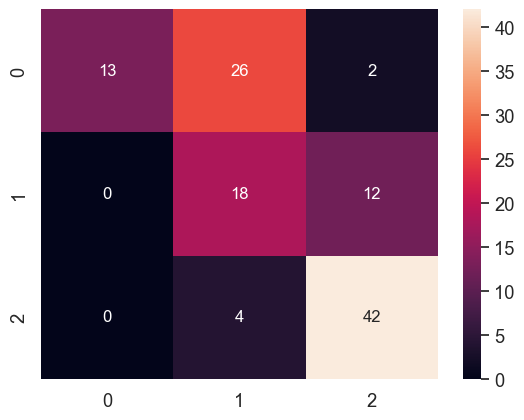

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        41
           1       0.38      0.60      0.46        30
           2       0.75      0.91      0.82        46

    accuracy                           0.62       117
   macro avg       0.71      0.61      0.59       117
weighted avg       0.74      0.62      0.61       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[533.895 482.35  432.694 586.381 321.183 344.531 598.916 627.233 441.598
 435.897 634.499 328.351 400.578 401.946 365.722 623.382 396.606 580.161
 383.309 495.979 365.921 421.673 461.78  745.591 349.781 399.363 292.584
 548.002 511.791 442.666 496.143 312.613 234.967 524.048 365.532 424.524
 519.96  800.677 392.477 300.25  471.278 414.311 397.783 355.482 223.707
 422.811 795.058 391.915 557.384 265.969 282.845 222.306 536.856 268.178
 504.066 417.341 532.918 450.647 297.302 265.828 829.286 432.049 292.726
 207.181 696.324

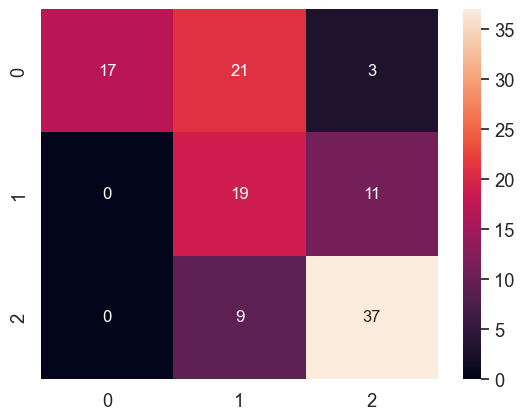

              precision    recall  f1-score   support

           0       1.00      0.41      0.59        41
           1       0.39      0.63      0.48        30
           2       0.73      0.80      0.76        46

    accuracy                           0.62       117
   macro avg       0.70      0.62      0.61       117
weighted avg       0.74      0.62      0.63       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[338.43  536.793 481.314 640.844 460.593 392.845 539.167 687.96  525.135
 495.756 545.024 496.149 339.706 426.423 458.17  419.705 304.216 541.865
 337.914 327.448 380.026 292.569 523.638 794.123 332.912 329.853 230.542
 522.213 605.962 472.003 465.039 308.171 248.712 364.669 364.053 475.097
 479.717 812.417 393.736 314.795 599.461 552.155 488.457 266.131 436.523
 481.136 872.339 348.592 312.526 367.174 316.006 215.527 488.418 319.738
 420.931 487.027 501.49  434.683 397.153 386.967 748.002 345.998 198.776
 243.688 767.857

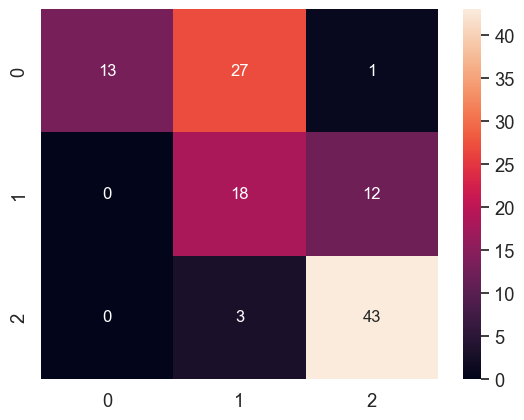

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        41
           1       0.38      0.60      0.46        30
           2       0.77      0.93      0.84        46

    accuracy                           0.63       117
   macro avg       0.71      0.62      0.60       117
weighted avg       0.75      0.63      0.62       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[594.257 686.107 642.573 619.544 452.889 371.495 496.172 762.32  549.943
 491.977 643.152 318.454 279.175 375.79  421.385 555.518 347.888 657.55
 395.502 367.342 372.286 412.547 382.438 713.074 291.423 387.713 301.81
 503.258 628.243 465.154 551.909 411.309 296.714 616.394 282.767 590.281
 471.142 864.147 431.73  217.539 574.302 415.689 636.617 330.916 287.079
 364.398 723.944 317.977 319.155 325.97  450.916 301.175 525.712 290.245
 459.834 493.681 473.263 494.457 299.3   321.121 834.245 394.929 260.805
 219.671 672.329 3

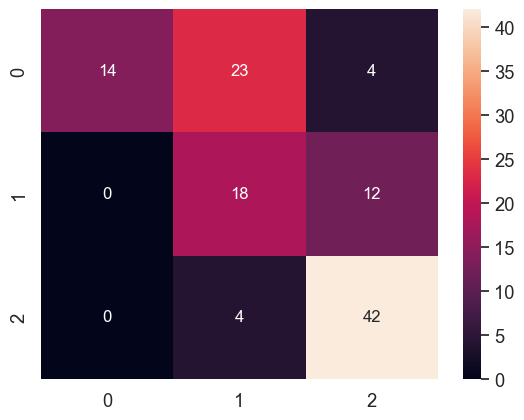

              precision    recall  f1-score   support

           0       1.00      0.34      0.51        41
           1       0.40      0.60      0.48        30
           2       0.72      0.91      0.81        46

    accuracy                           0.63       117
   macro avg       0.71      0.62      0.60       117
weighted avg       0.74      0.63      0.62       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[459.493 513.488 579.823 587.659 501.496 389.123 458.499 625.821 487.788
 432.335 592.061 408.868 322.995 386.863 404.413 418.72  317.867 629.096
 334.78  455.072 368.129 430.4   516.788 720.457 309.25  316.914 242.177
 564.31  471.978 556.103 494.862 357.249 326.293 489.71  276.75  524.379
 514.37  787.204 404.466 267.757 551.004 496.142 515.421 413.703 285.796
 419.863 734.076 303.368 343.278 322.928 374.791 270.399 469.319 304.008
 433.207 363.828 525.447 399.431 325.19  265.99  778.939 428.36  270.189
 262.531 712.673

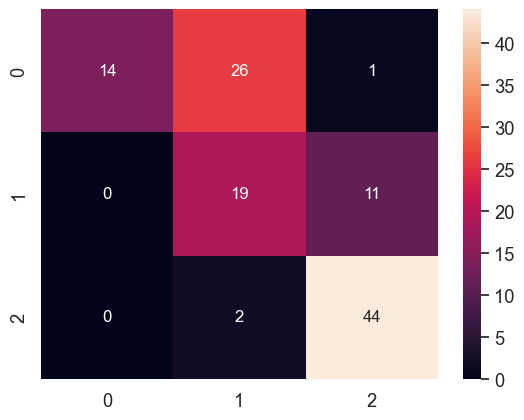

              precision    recall  f1-score   support

           0       1.00      0.34      0.51        41
           1       0.40      0.63      0.49        30
           2       0.79      0.96      0.86        46

    accuracy                           0.66       117
   macro avg       0.73      0.64      0.62       117
weighted avg       0.76      0.66      0.64       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[ 314.13   630.22   451.755  610.25   445.58   290.49   469.64  1213.585
  492.78   483.33   578.86   383.26   242.42   373.185  398.195  452.385
  326.45   532.065  359.175  418.68   372.395  333.215  420.745 1088.03
  195.39   240.79   202.395  672.41   563.53   493.345  517.64   277.51
  263.805  345.15   499.51   414.64   528.07  1203.435  404.445  151.435
  522.265  588.59   444.025  329.4    227.345  359.75  1531.455  283.005
  352.885  234.49   237.32   218.5    404.99   185.61   449.54   394.115
  601.705  340.29 

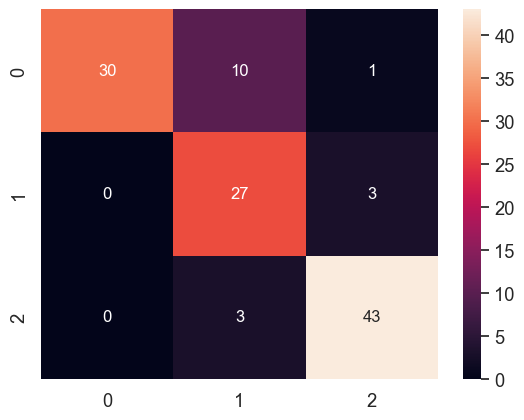

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        41
           1       0.68      0.90      0.77        30
           2       0.91      0.93      0.92        46

    accuracy                           0.85       117
   macro avg       0.86      0.86      0.85       117
weighted avg       0.88      0.85      0.86       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[677.703 739.694 541.826 557.402 417.291 355.797 438.644 615.015 480.616
 446.894 659.662 357.702 289.251 341.513 340.388 544.723 332.433 525.579
 365.209 264.378 353.944 384.132 395.449 699.972 296.849 389.679 239.7
 455.216 594.465 602.075 443.676 414.015 287.28  615.341 529.221 510.393
 628.772 837.459 567.737 229.32  532.192 435.895 693.312 279.735 275.97
 354.893 806.872 321.627 378.031 281.322 307.315 264.83  477.402 325.891
 457.683 433.984 443.611 362.915 262.125 353.131 826.935 437.702 259.691
 233.163 662.186 33

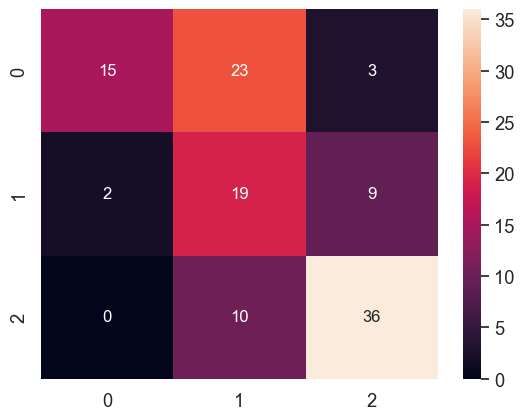

              precision    recall  f1-score   support

           0       0.88      0.37      0.52        41
           1       0.37      0.63      0.46        30
           2       0.75      0.78      0.77        46

    accuracy                           0.60       117
   macro avg       0.67      0.59      0.58       117
weighted avg       0.70      0.60      0.60       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[777.843 654.114 600.034 542.265 445.569 360.355 503.037 652.781 508.156
 366.907 598.087 320.729 276.489 370.034 397.728 556.494 345.998 548.414
 403.499 367.28  312.883 329.364 410.538 653.487 363.722 395.495 315.779
 544.265 553.041 617.606 509.464 370.784 264.303 668.699 488.847 549.512
 487.056 804.369 562.719 235.075 525.414 382.317 728.299 313.017 263.408
 363.353 826.353 297.159 306.611 236.675 313.473 250.778 486.91  284.714
 535.99  402.595 499.844 425.554 293.573 363.43  829.55  501.964 242.271
 258.164 624.983

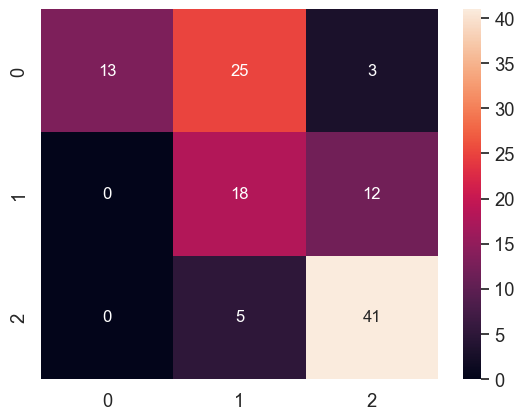

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        41
           1       0.38      0.60      0.46        30
           2       0.73      0.89      0.80        46

    accuracy                           0.62       117
   macro avg       0.70      0.60      0.58       117
weighted avg       0.73      0.62      0.60       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[355.645 606.049 443.456 492.712 424.322 290.905 502.505 794.472 483.603
 445.55  484.292 379.189 260.296 326.036 383.066 444.546 278.723 514.286
 342.576 377.982 345.775 452.497 408.297 874.469 259.178 290.208 284.652
 606.793 790.294 468.497 427.868 388.539 319.09  416.413 414.948 370.256
 537.859 811.253 393.936 229.353 495.872 471.989 475.484 279.104 251.143
 377.98  866.752 251.186 454.16  258.309 261.411 289.34  401.153 296.851
 465.032 414.575 577.586 423.452 445.477 544.119 858.234 367.637 329.524
 265.522 705.64 

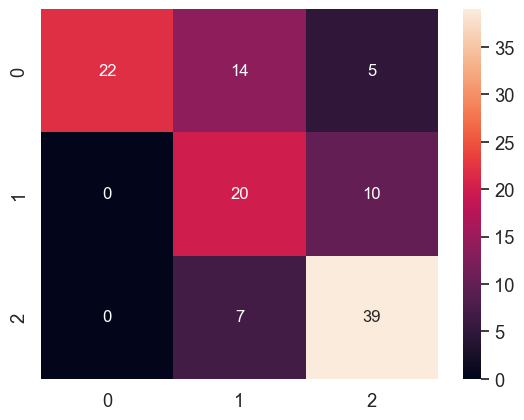

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        41
           1       0.49      0.67      0.56        30
           2       0.72      0.85      0.78        46

    accuracy                           0.69       117
   macro avg       0.74      0.68      0.68       117
weighted avg       0.76      0.69      0.70       117

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[510.571 658.272 492.64  573.534 423.594 410.454 551.725 744.111 510.554
 456.312 514.539 397.014 289.565 394.471 469.131 503.758 295.971 527.724
 340.513 466.055 379.928 348.317 448.862 771.16  259.256 346.064 280.311
 653.778 641.037 514.078 497.34  331.194 280.195 443.994 369.557 512.644
 481.455 843.737 460.241 211.166 506.021 472.246 595.758 251.843 247.766
 393.134 885.376 232.385 452.411 226.454 308.98  296.166 392.717 291.817
 540.322 364.719 625.487 400.037 416.021 449.106 770.843 477.239 190.498
 264.843 719.023

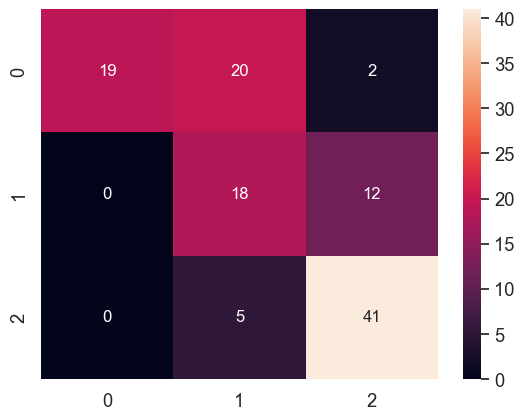

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        41
           1       0.42      0.60      0.49        30
           2       0.75      0.89      0.81        46

    accuracy                           0.67       117
   macro avg       0.72      0.65      0.65       117
weighted avg       0.75      0.67      0.67       117



In [55]:
from sklearn.metrics import confusion_matrix, classification_report

for Si in S:
    X_train_ = np.array(prune(x_train,Si))
    X_test_ = np.array(prune(x_test,Si))

    print(X_train_.shape)
    print(X_test_.shape)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    # Fit the random search model
    print(X_train_.shape)
    rf_random.fit(X_train_, y_train)
    rf_random.best_params_
    best_grid = rf_random.best_estimator_
    meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train_, y_train)
    print(meanSE, medianSE, stdSE, spearmanR)
    y_pred2=best_grid.predict(X_test_)
    print(y_pred2)
    for hh in y_pred2:
        print(hh)
    y_train_v, y_pred_v = classif(y_train,y_pred)
    cm = confusion_matrix(y_train_v, y_pred_v)

    sns.set(font_scale=1.2) 
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 
    plt.show()
    print(classification_report(y_train_v, y_pred_v))


In [22]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [24]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 40,
 'bootstrap': True}

In [25]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'min_samples_leaf': [2, 4, 6],
#     'min_samples_split': [2, 5, 6],
#     'max_depth': [30,20,10],
#     'n_estimators': [200, 300, 100],
#     'bootstrap': [True]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 4)
# grid_search.fit(X_train_, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 20, 10],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 6],
                         'n_estimators': [200, 300, 100]},
             verbose=4)

In [26]:
# grid_search.best_params_


{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'n_estimators': 100}

In [28]:
# # grid_search.best_params_
# # best_grid = grid_search.best_estimator_
# # meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_test, y_test)
# # print(meanSE, medianSE, stdSE, spearmanR)

# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train_, y_train)
# print(meanSE, medianSE, stdSE, spearmanR)

[348.877 673.016 440.453 592.137 546.006 465.872 529.06  845.568 444.971
 416.994 468.946 433.853 350.688 452.718 469.046 448.735 294.511 509.935
 410.343 420.934 389.36  249.368 528.081 792.448 270.117 301.681 286.255
 690.097 643.614 458.675 550.163 317.908 323.345 311.249 254.302 504.415
 627.95  808.31  401.876 332.685 502.061 547.663 679.973 534.473 313.159
 352.217 855.764 420.634 321.786 434.956 262.071 363.339 405.322 301.501
 360.936 308.097 541.724 419.612 434.964 399.604 647.214 328.304 289.907
 203.767 617.045 332.777 321.27  698.158 370.085 463.089 239.837 456.945
 431.59  538.992 425.407 266.215 505.089 547.789 250.767 323.672 433.123
 305.533 392.852 432.04  460.63  347.23  442.083 646.157 505.721 549.871
 444.878 437.853 514.677 599.41  355.628 464.043 643.647 349.53  544.359
 445.208 603.893 403.974 605.672 243.541 622.74  398.565 641.401 451.837
 511.793 307.245 431.398 439.49  578.832 563.078 664.716 393.261 273.317]
64218.86713282762 13668.235153637075 147430.219232

In [30]:
y_pred2=best_grid.predict(X_test_)
print(y_pred2)
for hh in y_pred2:
    print(hh)

[576.112 522.188 623.189 506.18  626.935 556.582 557.636 574.672 579.395
 399.342 425.538 515.92  498.272 429.075 514.714 690.881 610.227 717.906
 628.354 667.252 568.871 573.683 539.936 585.392 587.343 575.423 674.131
 673.172]
576.111802506661
522.1878966310605
623.189307715719
506.1804408612973
626.9354522319355
556.5822174725
557.6358890987324
574.6723783644117
579.3954938766515
399.34157980963823
425.53827219422294
515.9197707186173
498.2718175774173
429.07504269114094
514.7136776687364
690.881381056508
610.2268218856307
717.9059869514302
628.354366989134
667.2519247628447
568.8707071564488
573.6826732676508
539.9360444870746
585.3922220582139
587.3430560852977
575.4227631560047
674.1314771608679
673.1715436221843


In [34]:
       
y_test_v = []
y_pred_v = []
for yi in y_train:
    if (yi < 300):
        y_test_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_test_v.append(1)
    else:
        y_test_v.append(2)

for yi in y_pred:
    if (yi < 300):
        y_pred_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_pred_v.append(1)
    else:
        y_pred_v.append(2)
        

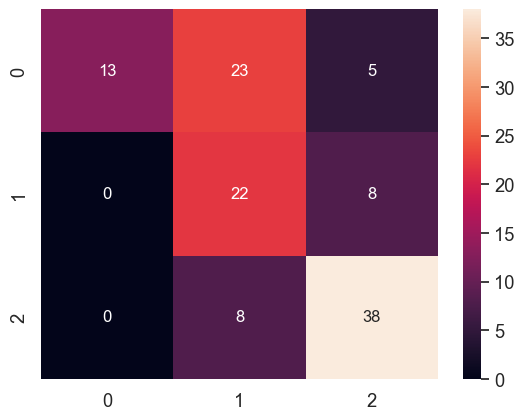

In [35]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_v, y_pred_v)

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test_v, y_pred_v))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        41
           1       0.42      0.73      0.53        30
           2       0.75      0.83      0.78        46

    accuracy                           0.62       117
   macro avg       0.72      0.63      0.60       117
weighted avg       0.75      0.62      0.61       117

